<a href="https://colab.research.google.com/github/adnanbimafertino2004-eng/Jogja-Tourism-Map-by-Adnan-Bima-Fertino/blob/main/Project_Yogyakarta_Tourism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Installing the required library (usually Folium is already installed, but this is to ensure it)
!pip install pandas folium scikit-learn matplotlib

/tmp/ipython-input-1786699058.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_jogja, x='cluster', palette='rainbow')


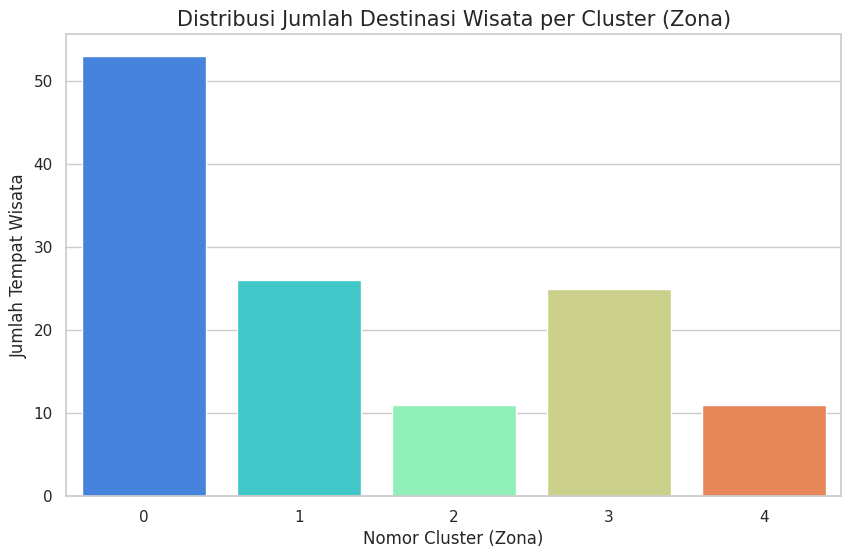

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Konfigurasi gaya visual
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Membuat Bar Plot
ax = sns.countplot(data=df_jogja, x='cluster', palette='rainbow')

plt.title('Distribusi Jumlah Destinasi Wisata per Cluster (Zona)', fontsize=15)
plt.xlabel('Nomor Cluster (Zona)', fontsize=12)
plt.ylabel('Jumlah Tempat Wisata', fontsize=12)
plt.show()

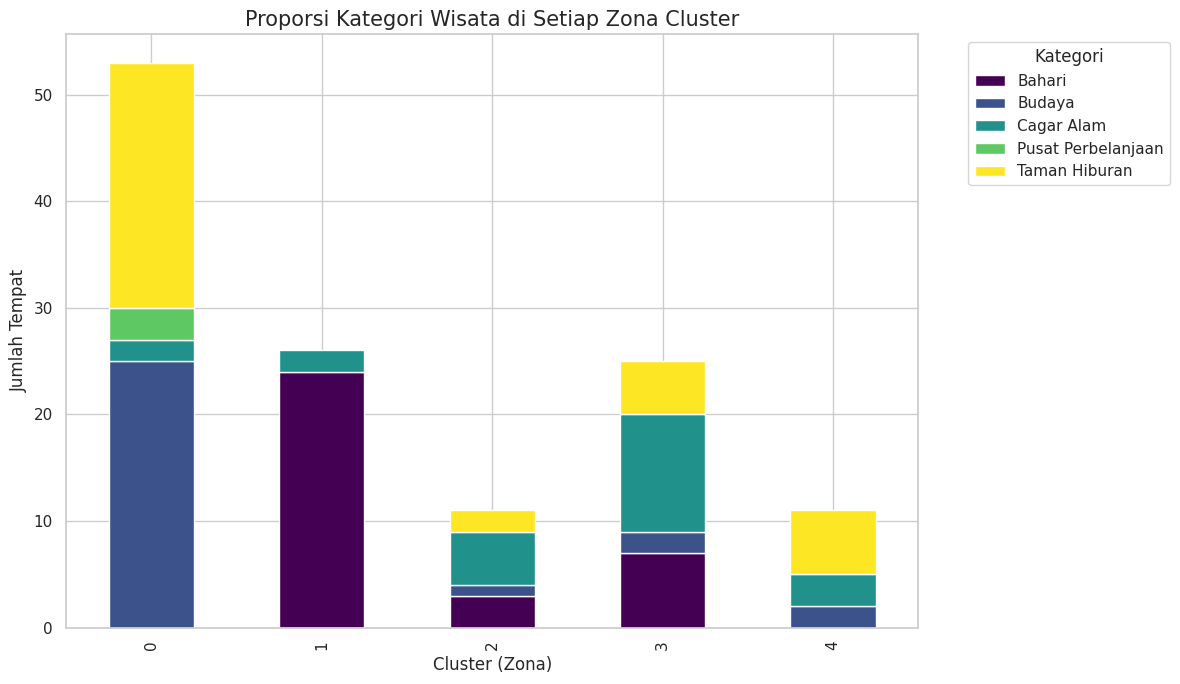

In [ ]:
# Membuat tabel silang (Crosstab) antara Cluster dan Kategori
cross_tab = pd.crosstab(df_jogja['cluster'], df_jogja['Category'])

# Plotting
cross_tab.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')

plt.title('Proporsi Kategori Wisata di Setiap Zona Cluster', fontsize=15)
plt.xlabel('Cluster (Zona)', fontsize=12)
plt.ylabel('Jumlah Tempat', fontsize=12)
plt.legend(title='Kategori', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# ==============================================================================
# PROJECT: YOGYAKARTA SPATIAL INTELLIGENCE
# ==============================================================================

import pandas as pd
import folium
from folium.plugins import Search, MarkerCluster, FeatureGroupSubGroup
from google.colab import files

print("🚀 Memulai pembuatan peta dengan Layout Rapi...")

# --- 1. DATA PROCESSING ---
try:
    places = pd.read_csv('tourism_with_id.csv')
    ratings = pd.read_csv('tourism_rating.csv')
    users = pd.read_csv('user.csv')

    # Filter Data Jogja
    df_jogja = places[places['City'] == 'Yogyakarta'].copy().dropna(subset=['Lat', 'Long'])

    # Analisis Demografi
    rating_user = pd.merge(ratings, users, on='User_Id')
    origin_stats = rating_user.groupby('Place_Id')['Location'].agg(
        lambda x: x.mode()[0] if not x.mode().empty else 'Belum ada data'
    ).reset_index()
    origin_stats.columns = ['Place_Id', 'Dominant_Origin']

    # Analisis Review
    review_stats = ratings.groupby('Place_Id')['Place_Ratings'].count().reset_index()
    review_stats.columns = ['Place_Id', 'Total_Reviews']

    # Gabung Data
    df_jogja = pd.merge(df_jogja, origin_stats, on='Place_Id', how='left')
    df_jogja = pd.merge(df_jogja, review_stats, on='Place_Id', how='left')
    df_jogja['Total_Reviews'] = df_jogja['Total_Reviews'].fillna(0)
    df_jogja['Dominant_Origin'] = df_jogja['Dominant_Origin'].fillna("-")

    # Statistik Global
    total_tempat = len(df_jogja)
    avg_rating_kota = df_jogja['Rating'].mean()
    kategori_terbanyak = df_jogja['Category'].mode()[0]

except Exception as e:
    print(f"❌ Error Data: {e}")
    exit()

# --- 2. SETUP PETA ---
m = folium.Map(location=[df_jogja['Lat'].mean(), df_jogja['Long'].mean()], zoom_start=13, control_scale=True)

main_cluster = MarkerCluster(control=False).add_to(m)
search_group = folium.FeatureGroup(name="🔍 Data Pencarian", show=False).add_to(m)

# --- 3. MARKER LOOP ---
for kat in df_jogja['Category'].unique():
    layer_group = FeatureGroupSubGroup(main_cluster, name=f"Wisata {kat}").add_to(m)
    data_kat = df_jogja[df_jogja['Category'] == kat]

    for _, row in data_kat.iterrows():
        revs = row['Total_Reviews']
        if revs > 30: color = 'red'
        elif revs > 15: color = 'orange'
        else: color = 'blue'

        popup_html = f"""
        <div style="font-family:'Segoe UI', sans-serif; width:220px;">
            <b>{row['Place_Name']}</b><br>
            <span style="font-size:11px; color:gray;">{row['Category']}</span>
            <hr style="margin:5px 0;">
            ⭐ {row['Rating']} | 👤 {int(revs)} ulasan<br>
            💰 Rp {row['Price']:,}<br>
            <div style="margin-top:5px; font-size:11px; color:darkblue;">
                📍 Asal: {row['Dominant_Origin']}
            </div>
        </div>
        """

        folium.Marker(
            location=[row['Lat'], row['Long']],
            popup=folium.Popup(popup_html, max_width=250),
            tooltip=row['Place_Name'],
            icon=folium.Icon(color=color, icon='info-sign')
        ).add_to(layer_group)

        folium.CircleMarker(location=[row['Lat'], row['Long']], radius=0, fill_opacity=0, tooltip=row['Place_Name']).add_to(search_group)

# --- 4. PERBAIKAN LAYOUT (CSS POSITIONS) ---

# A. DASHBOARD (Digeser ke bawah sedikit agar tidak menimpa Layer Control di pojok kanan atas)
# Perhatikan "top: 80px" -> Ini kuncinya supaya gak numpuk
dashboard_html = f'''
<div style="position: fixed; top: 80px; right: 10px; width: 170px;
    background: rgba(255,255,255,0.9); z-index:900; border-radius: 8px;
    padding: 10px; border-right: 5px solid #2980b9;
    box-shadow: 0 2px 5px rgba(0,0,0,0.2); font-family: sans-serif;">
    <h6 style="margin:0;">📊 Statistik Jogja</h6>
    <div style="font-size:11px; margin-top:5px;">
        Total: <b>{total_tempat}</b> Lokasi<br>
        Rating: <b style="color:#f39c12">★ {avg_rating_kota:.1f}</b><br>
        Top: <b>{kategori_terbanyak}</b>
    </div>
</div>
'''
m.get_root().html.add_child(folium.Element(dashboard_html))

# B. LEGENDA (Pojok Kiri Bawah - Aman)
legend_html = '''
<div style="position: fixed; bottom: 30px; left: 20px; width: 150px;
    background: white; z-index:900; border-radius: 8px; padding: 10px;
    border: 1px solid #ccc; font-family: sans-serif; font-size:10px;">
    <b>Legenda Popularitas</b><br>
    <i style="background:red; width:8px; height:8px; display:inline-block; border-radius:50%;"></i> Ramai (>30)<br>
    <i style="background:orange; width:8px; height:8px; display:inline-block; border-radius:50%;"></i> Sedang (15-30)<br>
    <i style="background:blue; width:8px; height:8px; display:inline-block; border-radius:50%;"></i> Normal (<15)
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# C. TOMBOL INFO & MODAL (Pojok Kanan Bawah - Diberi jarak dari pinggir)
docs_html = """
<style>
.info-btn {
    position: fixed; bottom: 30px; right: 20px;
    background-color: #27ae60; color: white; border: none;
    padding: 10px 15px; border-radius: 50px; cursor: pointer;
    z-index: 1000; font-weight: bold; font-family: sans-serif;
    box-shadow: 2px 2px 5px rgba(0,0,0,0.3);
}
.modal { display: none; position: fixed; z-index: 9999; left: 0; top: 0; width: 100%; height: 100%; overflow: auto; background-color: rgba(0,0,0,0.6); }
.modal-content { background-color: #fff; margin: 5% auto; padding: 20px; border: 1px solid #888; width: 80%; max-width: 700px; border-radius: 10px; font-family: sans-serif; }
.close { float: right; font-size: 28px; font-weight: bold; cursor: pointer; }
</style>

<button class="info-btn" onclick="document.getElementById('docModal').style.display='block'">
    ℹ️ Info Proyek
</button>

<div id="docModal" class="modal">
  <div class="modal-content">
    <span class="close" onclick="document.getElementById('docModal').style.display='none'">&times;</span>
    <h3 style="color:#2c3e50; text-align:center;">Analisis Nilai Guna Platform</h3>
    <hr>
    <p><b>1. Bagi Wisatawan:</b> Memudahkan perencanaan dengan filter kategori dan validasi tempat populer berbasis data rating.</p>
    <p><b>2. Bagi Bisnis:</b> Mengetahui profil "Asal Wisatawan" (Origin Profiling) untuk target pemasaran.</p>
    <p><b>3. Bagi Pemerintah:</b> Memantau persebaran pariwisata dan kualitas layanan melalui rating rata-rata kota.</p>
    <br>
    <small style="display:block; text-align:center; color:gray;">Spatial Intelligence Project © 2024</small>
  </div>
</div>
<script>
window.onclick = function(event) { if (event.target == document.getElementById('docModal')) { document.getElementById('docModal').style.display = "none"; } }
</script>
"""
m.get_root().html.add_child(folium.Element(docs_html))

# --- 5. FINISHING ---
# Search Bar (Pojok Kiri Atas - Default)
Search(layer=search_group, geom_type='Point', placeholder="Cari lokasi...", search_label='tooltip').add_to(m)

# Layer Control (Pojok Kanan Atas - Default)
# Karena dashboard sudah diturunkan (top:80px), Layer Control aman di paling atas.
folium.LayerControl(collapsed=False).add_to(m)

nama_file = "Dashboard_Rapi_Final.html"
m.save(nama_file)
print("✅ Layout Rapi Selesai! File sedang diunduh...")
files.download(nama_file)
m

🚀 Memulai pembuatan peta dengan Layout Rapi...
✅ Layout Rapi Selesai! File sedang diunduh...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>